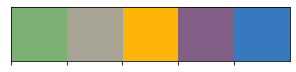

In [1]:
#!/usr/bin/env python
# coding: utf-8

# Sarahfong


# 2019-06-03 - created and run on common variants AF > 0.01

##### updates #####

# 2019-06-10
    # AF calculation was not correct. 0.01<= AF <0.5 is the maf, and 0.5=<AF=<1 is the AF
    # SNPs recalculated as maf.
    # Instead of intersecting only common variants (AF >= 0.01), intersect all variants.
    # maf rounded to 7th decimal


# Analyze the genomic shuffle of FANTOM eRNA enhancers for breaks v. actual transcribed enhancers.


import glob
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
import numpy as np
import os, sys
from scipy import stats
import seaborn as sns
import subprocess

sys.path.append("/dors/capra_lab/users/fongsl/tools/py_/")
import config_readwrite as crw
import plot_params as pp
import split_filename

pp.fonts()

sys.path.append("/dors/capra_lab/users/fongsl/tools/genome/")
import make_windows 
import match_seq_lengths

sys.path.append("/dors/capra_lab/users/fongsl/tools/evo/")
import syn_gen_background 
colors = ["faded green", "greyish",  "amber", "dusty purple", "windows blue",]
palette = sns.xkcd_palette(colors)
sns.palplot(palette)

In [2]:
name = "/dors/capra_lab/users/fongsl/enh_ages/core_v_derived/config_landscape"
config, config_filename = crw.read_config(name)

WINDOW_SIZE = int(config["WINDOWS"]["window_size_10"])
RE = config["1KG"]["results"]

COMPLEX = config["1KG"]["fantom_complexenh"] ## file w/ complex bed coords
SIMPLE = config["1KG"]["FANTOM_simple"]

ONEKG_SLRUM_SCRIPT = config["1KG"]["1kg_intersection_slurm"]  # slurm script for intersecting bed w/ 1kg
fs =[SIMPLE, COMPLEX]

ONEKG_BEDS = [config["1KG"][f"1kg_complex_windows_{(WINDOW_SIZE-1)}"], 
              config[f"1KG"][f"1kg_simple_windows_{(WINDOW_SIZE-1)}"]
             ]
BREAKS = config["FANTOM"]["data_file"]  # original file on fantom enhancers and breaks. 

BUILD = "hg19"

In [3]:
def get_dataframes(file_list, syngenbkgd):

    files_dict= {}
    for file in file_list:
        path, filename, sid = split_filename.split_filename(file)
        df = pd.read_csv(file, sep = '\t', header = None)


        df.columns = ["chr_syn", "start_syn", "end_syn", "order", 
                      "chr_enh", "start_enh", "end_enh",
                      "mrca", "enh_id",
                     "chr_snp", "pos-1", "pos", "qual", "AF", 
                      'EAS_AF_maf','AMR_AF_maf', 'AFR_AF_maf', 'EUR_AF_maf', 'SAS_AF_maf','id']

        
        df["code"] = sid.split("_")[1]
        df["mrca"] = df["mrca"].round(3)
        df["AF"] = df["AF"].astype(float)
        df["dataset"] = "FANTOM"
        df["syn_id"] = df.chr_syn + ":" + df.start_syn.map(str) + "-" + df.end_syn.map(str)
        df["syn_len"] = df["end_syn"] - df["start_syn"] # compute bin length
        df["enh_len"] = df["end_enh"] - df["start_enh"] # compute enh length
        
        
        df = df.drop(columns = ['EAS_AF_maf','AMR_AF_maf', 'AFR_AF_maf', 'EUR_AF_maf', 'SAS_AF_maf','id'])
        files_dict[sid] = df # add to dictionary


    df = pd.concat(files_dict.values()) # concat enh dictionaries

    df = pd.merge(df,syngenbkgd, how = "left", on = "mrca") # taxon names

    
    # create rank system for simple, complex elements
    df["core_remodeling"] = 1
    df.loc[df["code"] == "simple", "core_remodeling"] = 0
    df["counts"] = 1


    return df

# separate bedfiles into window sizes
- if the file is already made, will not remake 

In [4]:
windowed_fs = []

for f in fs:
    
    fwindows = make_windows.make_windows(f, WINDOW_SIZE)
    windowed_fs.append(fwindows)

# intersect w/ 1kg variants 
- chromosome by chromosome

In [5]:
for w in windowed_fs:
    
    cmd = f"sbatch {ONEKG_SLRUM_SCRIPT} {w} {RE}"
    print(cmd)
    subprocess.call(cmd, shell = True)

sbatch /dors/capra_lab/users/fongsl/enh_ages/core_v_derived/1000G/1kg_intersection.slurm /dors/capra_lab/projects/enhancer_ages/fantom/data/architecture_coordinates/all_fantom/FANTOM_simple_windows-11.bed /dors/capra_lab/projects/enhancer_ages/1000g/results/
sbatch /dors/capra_lab/users/fongsl/enh_ages/core_v_derived/1000G/1kg_intersection.slurm /dors/capra_lab/projects/enhancer_ages/fantom/data/architecture_coordinates/all_fantom/FANTOM_complexenh_windows-11.bed /dors/capra_lab/projects/enhancer_ages/1000g/results/


# Analysis

In [6]:
syngenbkgd = syn_gen_background.load_syn_gen_bkgd(BUILD)

df = get_dataframes(ONEKG_BEDS, syngenbkgd)
df = df.drop_duplicates()
df.head()

,chr_syn,start_syn,end_syn,order,chr_enh,start_enh,end_enh,mrca,enh_id,chr_snp,...,code,dataset,syn_id,syn_len,enh_len,taxon,mrca_2,taxon2,core_remodeling,counts
0,chr10,516106,516144,1,chr10,516106,516519,0.175,chr10:516106-516519,chr10,...,complexenh,FANTOM,chr10:516106-516144,38,413,Eutheria,0.175,Eutheria (105),1,1
1,chr10,516106,516144,1,chr10,516106,516519,0.175,chr10:516106-516519,chr10,...,complexenh,FANTOM,chr10:516106-516144,38,413,Eutheria,0.175,Eutheria (105),1,1
2,chr10,516106,516144,1,chr10,516106,516519,0.175,chr10:516106-516519,chr10,...,complexenh,FANTOM,chr10:516106-516144,38,413,Eutheria,0.175,Eutheria (105),1,1
3,chr10,516106,516144,1,chr10,516106,516519,0.175,chr10:516106-516519,chr10,...,complexenh,FANTOM,chr10:516106-516144,38,413,Eutheria,0.175,Eutheria (105),1,1
4,chr10,516106,516144,1,chr10,516106,516519,0.175,chr10:516106-516519,chr10,...,complexenh,FANTOM,chr10:516106-516144,38,413,Eutheria,0.175,Eutheria (105),1,1


# the problem with the last bin... 

In [7]:
last_bin_enh = list(df.loc[df["order"]==WINDOW_SIZE, "enh_id"].unique())[0]
df.loc[df.enh_id ==last_bin_enh, ["enh_id","order","syn_len"]].drop_duplicates()  # there are duplicates because more than 1 allele can overlap a bin. 

,enh_id,order,syn_len
0,chr10:516106-516519,1,38
5,chr10:516106-516519,2,38
7,chr10:516106-516519,3,38
9,chr10:516106-516519,4,38
10,chr10:516106-516519,6,38
11,chr10:516106-516519,8,38
13,chr10:516106-516519,9,38
16,chr10:516106-516519,11,33


# keep only complex enhancers w/ 3+ age segments and simple enhancers

In [9]:
BREAKS

'/dors/capra_lab/projects/enhancer_ages/fantom/data/non-genic/no-exon_all_fantom_enh/ages/syn_breaks_no-exon_all_fantom_enh_ages.bed'

In [10]:
cols =["chr_syn", "start_syn", "end_syn", "enh_id", 
                      "chr_enh", "start_enh", "end_enh",
                      "seg_index", "core_remodeling", "core","mrca",]
breaks = pd.read_csv(BREAKS, sep = '\t', header = None, names = cols)
breaks.head()

threeplus = set(breaks.loc[breaks['seg_index']>2, "enh_id"])
simple = set(breaks.loc[breaks['core_remodeling']==0, "enh_id"])
print(len(threeplus), len(simple))

1334 19767


## focus on 95% of data

In [11]:
df.drop_duplicates().shape, df.syn_len.min(), df.syn_len.max()

((286933, 24), 1, 260)

# keep only 3+ age seg complex enhancers and simple enhances

In [12]:
def calculate_snp_density(df):
    """
    return density of alleles in bin of variable sizes
    1. groupby to get the count of alleles for each enhancer, each bin number (order), with a set bin length. 
    2. calculate SNP density per bin (N alleles overlapping bin/ bin length)
    3. remove last bin because of inappropriate window size
    4. calculate SNP density z-score 
    
    """
    #1
    df = df.groupby(["core_remodeling", "enh_id", "order","syn_len", "enh_len"])["counts"].sum().reset_index()
    #2
    df["snp_density"] = df["counts"].divide(df["syn_len"])
    #3
    df = df.loc[df["order"]!= int(WINDOW_SIZE)]
    #4
    df["snp_density-Z"] = stats.zscore(df["snp_density"])
    
    return df

## calculate SNP density 

- only reason to treat this separately is to calculate z-score per enhancer sequence type

Text(0.5, 0, 'bin_len')

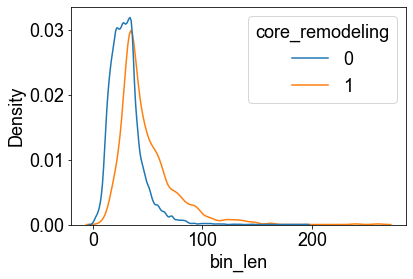

In [13]:
# get simple snp densities
simple_df = calculate_snp_density(df.loc[df["enh_id"].isin(simple)])

# get complex snp densities
threeplus_df = calculate_snp_density(df.loc[df["enh_id"].isin(threeplus)])

# concatenante simple and complex
bin_counts = pd.concat([simple_df, threeplus_df]).drop_duplicates().reset_index()

# plot bin distribution
sns.kdeplot(x="syn_len", data=bin_counts, hue="core_remodeling", common_norm = False)
plt.xlabel("bin_len")

## inner v. outer bin SNP density significantly different in simple or complex? 

In [14]:
outer = [1,2,9,10]
inner = [4,5,6,7,8]


s_inner = simple_df.loc[simple_df["order"].isin(inner), "snp_density"]
s_outer = simple_df.loc[simple_df["order"].isin(outer), "snp_density"]

print("simple SNP density inner v. outer\n", stats.ttest_ind(s_inner, s_outer, equal_var = False))

t_inner = threeplus_df.loc[threeplus_df["order"].isin(inner), "snp_density"]
t_outer = threeplus_df.loc[threeplus_df["order"].isin(outer), "snp_density"]


print("\n\nthreeplus complex SNP density inner v. outer\n", stats.ttest_ind(t_inner, t_outer, equal_var = False))

simple SNP density inner v. outer
 Ttest_indResult(statistic=-1.0988843619280706, pvalue=0.271821771153593)


threeplus complex SNP density inner v. outer
 Ttest_indResult(statistic=-1.306340797672466, pvalue=0.19147551363723253)


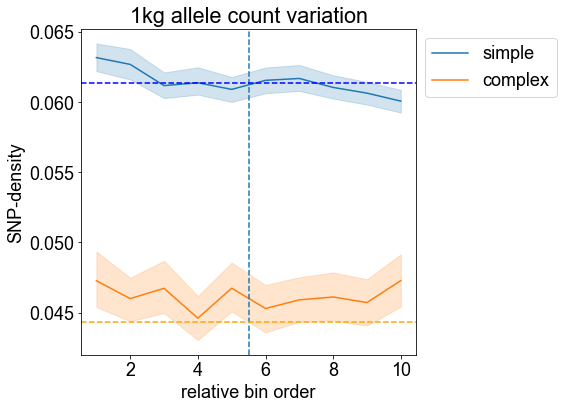

In [15]:
x="order"
y="snp_density"
data=bin_counts
hue = "core_remodeling"
fig, ax = plt.subplots(figsize = (6,6))
sns.lineplot(x=x, y=y, data=data, hue=hue, 
            #join = False
           )
ax.set(
    #ylim=(-1,1), 
       xlabel = "relative bin order", ylabel = "SNP-density",
title = '1kg allele count variation')
ax.axvline((int(WINDOW_SIZE)/2), ls="--")
ax.axhline(simple_df[y].mean(), ls = "--" ,color ="blue")
ax.axhline(threeplus_df[y].mean(), ls = "--" ,color ="orange")
ax.legend(["simple", "complex"],bbox_to_anchor = (1,1))

out = os.path.join(RE, "1kg_all_SNP_density.pdf")
plt.savefig(out, bbox_inches = 'tight')

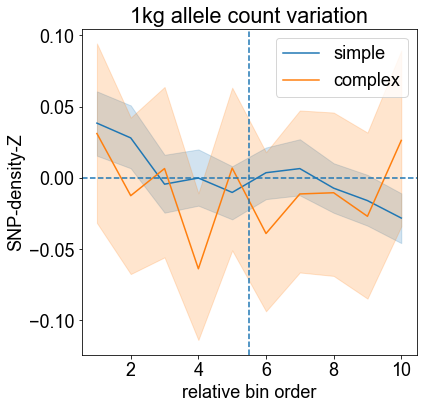

In [16]:
x="order"
y="snp_density-Z"
data=bin_counts
hue = "core_remodeling"
fig, ax = plt.subplots(figsize = (6,6))
sns.lineplot(x=x, y=y, data=data, hue=hue, 
            #join = False
           )
ax.set(
    #ylim=(-1,1), 
       xlabel = "relative bin order", ylabel = "SNP-density-Z",
title = '1kg allele count variation')
ax.axvline((int(WINDOW_SIZE)/2), ls="--")
ax.axhline(0, ls="--")
ax.legend(["simple", "complex"],bbox_to_anchor = (1,1))
out = os.path.join(RE, "1kg_all_SNP_density_z-score.pdf")
plt.savefig(out, bbox_inches = 'tight')

# match on enhancer sequence length 

['enh_id', 'enh_len']
2056 1103


Text(0.5, 0, 'bin_len')

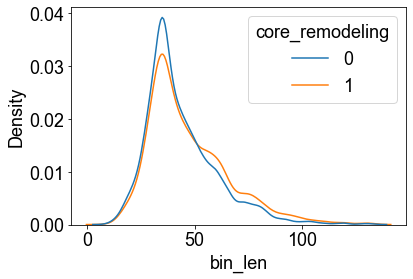

In [17]:
import match_seq_lengths

# specify columns for length matching
cols = ["enh_id", "enh_len"]

# match on length
matched_three_ids, matched_simple_ids = match_seq_lengths.match_len(threeplus_df, simple_df, 10, cols)

# subset simple_df by length matched enhancers
simple_df_matched = calculate_snp_density(simple_df.loc[simple_df['enh_id'].isin(matched_simple_ids)])

# subset threeplus df by length matched enhancers
threeplus_df_matched = calculate_snp_density(threeplus_df.loc[threeplus_df['enh_id'].isin(matched_three_ids)])

print(len(simple_df_matched["enh_id"].unique()), len(threeplus_df_matched["enh_id"].unique()))

# combine the two dataframes
bin_counts_matched = pd.concat([simple_df_matched, threeplus_df_matched]).drop_duplicates().reset_index()

sns.kdeplot(x="syn_len", data=bin_counts_matched, hue="core_remodeling", common_norm = False)
plt.xlabel("bin_len")

## is SNP density of simple significantly different from SNP density in complex?  

In [18]:
s_den_matched = simple_df_matched["snp_density"]
t_den_matched = threeplus_df_matched["snp_density"]
stats.ttest_ind(s_den_matched, t_den_matched, equal_var = False)

Ttest_indResult(statistic=1.330456000551411, pvalue=0.1833880833865999)

## Edge effects -  is flanking SNP density significantly different from either complex or simple length matched?  

In [19]:
outer = [1,2,3,8,9,10]
inner = [4,5,6,7]


s_inner = simple_df_matched.loc[simple_df_matched["order"].isin(inner), "snp_density"]
s_outer = simple_df_matched.loc[simple_df_matched["order"].isin(outer), "snp_density"]

print("simple length-matched SNP density inner v. outer\n", stats.ttest_ind(s_inner, s_outer, equal_var = False))

t_inner = threeplus_df_matched.loc[threeplus_df_matched["order"].isin(inner), "snp_density"]
t_outer = threeplus_df_matched.loc[threeplus_df_matched["order"].isin(outer), "snp_density"]


print("\n\nthreeplus complex length-matched SNP density inner v. outer\n", stats.ttest_ind(t_inner, t_outer, equal_var = False))

simple length-matched SNP density inner v. outer
 Ttest_indResult(statistic=0.9450407859105389, pvalue=0.3446578965756151)


threeplus complex length-matched SNP density inner v. outer
 Ttest_indResult(statistic=-0.5608599166380714, pvalue=0.5749114011588599)


## plot bin x snp density 

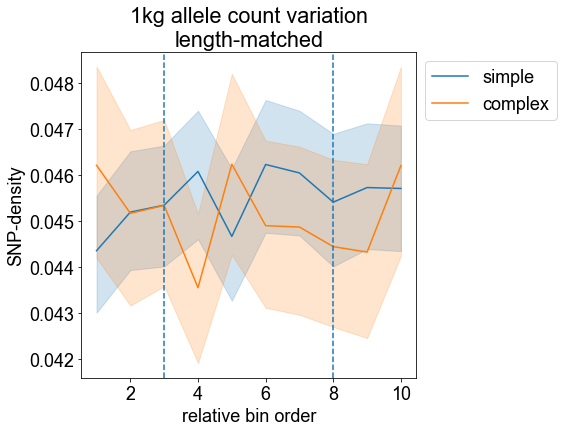

In [20]:
x="order"
y="snp_density"
data=bin_counts_matched
hue = "core_remodeling"
fig, ax = plt.subplots(figsize = (6,6))
sns.lineplot(x=x, y=y, data=data, hue=hue, ax=ax,
            #join = False
           )
ax.set(
       xlabel = "relative bin order", ylabel = "SNP-density",
       title = '1kg allele count variation\nlength-matched'
        )
#ax.axvline((int(WINDOW_SIZE)/2), ls="--")
ax.axvline(3, ls="--")
ax.axvline(8, ls="--")
#ax.axhline(bin_counts_matched[y].mean(), ls="--")
#ax.axhline(simple_df_matched[y].mean(), ls = "--" ,color ="blue")
#ax.axhline(threeplus_df_matched[y].mean(), ls = "--" ,color ="orange")
ax.legend(["simple", "complex"],bbox_to_anchor = (1,1))

out = os.path.join(RE, "1kg_length-matched_SNP_density.pdf")
plt.savefig(out, bbox_inches = 'tight')


## plot bin x snp density z-score

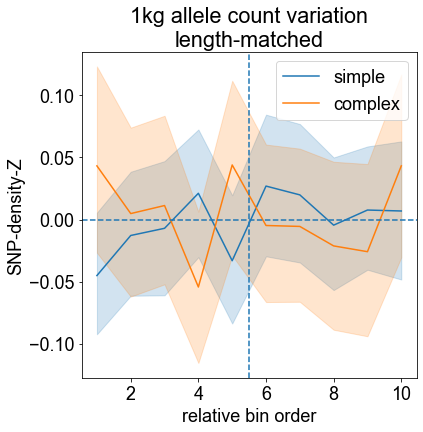

In [21]:
x="order"
y="snp_density-Z"
data=bin_counts_matched
hue = "core_remodeling"
fig, ax = plt.subplots(figsize = (6,6))

sns.lineplot(x=x, y=y, data=data, hue=hue, 
            ax=ax,
             )
ax.set(
        xlabel = "relative bin order", ylabel = "SNP-density-Z",
        title = '1kg allele count variation\nlength-matched'
        )


ax.axvline((int(WINDOW_SIZE)/2), ls="--")
ax.axhline(0, ls="--")
ax.legend(["simple", "complex"],bbox_to_anchor = (1,1))
out = os.path.join(RE, "1kg_length-matched_SNP_density_Z-score.pdf")
plt.savefig(out, bbox_inches = 'tight')

In [22]:
breaks["mrca"] = breaks["mrca"].round(3)
breaks = pd.merge(breaks, syngenbkgd, how ="left")

In [46]:
max_ages = breaks[["enh_id", "mrca_2"]].drop_duplicates().groupby(['enh_id'])["mrca_2"].max().reset_index()

In [50]:
bin_counts_matched = pd.merge(bin_counts_matched[['core_remodeling',
 'enh_id',
 'order',
 'syn_len',
 'enh_len',
 'counts',
 'snp_density',
 'snp_density-Z']],max_ages, how = "left")
bin_counts_matched = pd.merge(bin_counts_matched, breaks[["enh_id", "mrca_2", "taxon2"]].drop_duplicates(), how = "left")

In [51]:
list(bin_counts_matched)

['core_remodeling',
 'enh_id',
 'order',
 'syn_len',
 'enh_len',
 'counts',
 'snp_density',
 'snp_density-Z',
 'mrca_2',
 'taxon2']

In [52]:
list(set(bin_counts_matched.mrca_2))

ages = [0.957,  0.656,0.49,  0.38, 0.308, 0.175,0.152, 0.131] #0.126]

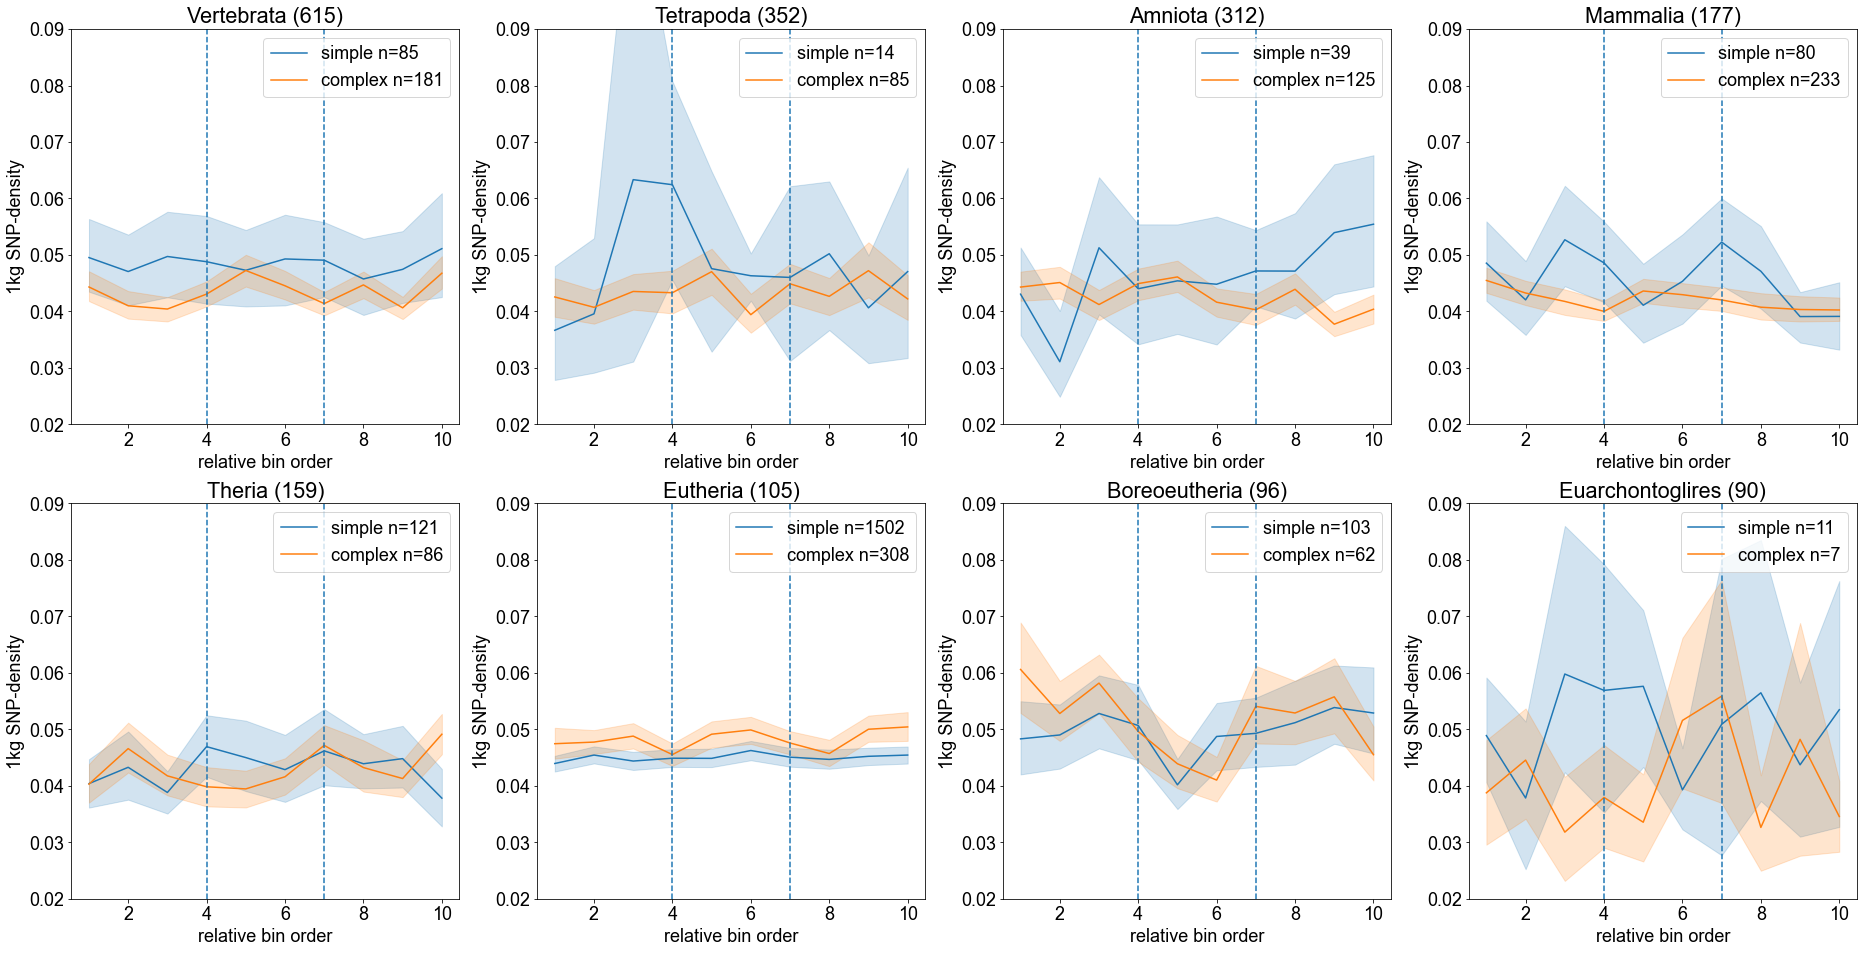

In [55]:
results = {}


fig, ax_ = plt.subplots(ncols = 4, nrows = 2, figsize = (32,16))

row = 0

for i, age in enumerate(ages):
    if i<4:
        ax = ax_[row][i]
    elif i%4 ==0:
        row = 1
        ax = ax_[row][i-4]
    else:
        ax = ax_[row][i-4]
    x="order"
    y="snp_density"
    data=bin_counts_matched.loc[bin_counts_matched["mrca_2"]==age]
    hue = "core_remodeling"
    title = data['taxon2'].iloc[0]
    
    simplen, complexn = data[["core_remodeling", 'enh_id']].drop_duplicates().groupby("core_remodeling")["enh_id"].count().reset_index()["enh_id"]
    
    
    sns.lineplot(x=x, y=y, data=data, hue=hue, ax=ax,
                #join = False
               )
    ax.set(
           xlabel = "relative bin order", ylabel = "1kg SNP-density",
           title = f'{title}',
           ylim =(0.02, 0.09), 
            )
    
    ax.axvline(4, ls="--")
    ax.axvline(7, ls="--")
    ax.legend([f"simple n={simplen}", f"complex n={complexn}"], loc = "upper right")
    
   

out = os.path.join(RE, "1kg_length-matched_SNP_density_agestratified.pdf")
plt.savefig(out, bbox_inches = 'tight')

In [41]:
simplen, complexn

(11, 190)

In [44]:
bin_counts_matched[["core_remodeling", 'enh_id']].drop_duplicates().groupby("core_remodeling")["enh_id"].count().reset_index()["enh_id"]

0    2022
1    1134
Name: enh_id, dtype: int64

In [ ]:
bin_counts_matched